In [1]:
import numpy as np

In [2]:
import os

TITANIC_PATH = os.path.join("datasets", "titanic")

In [3]:
import pandas as pd

def load_titanic_data(filename, titanic_path=TITANIC_PATH):
    csv_path = os.path.join(titanic_path, filename)
    return pd.read_csv(csv_path)

In [4]:
train_data = load_titanic_data("train.csv")
test_data = load_titanic_data("test.csv")

In [5]:
from sklearn.preprocessing import LabelEncoder
X = train_data.drop(['Survived'], axis=1)
y = train_data['Survived'].values
np.unique(y)

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

print("X.shape: {} y.shape: {}".format(X.shape, y.shape))

X.shape: (891, 11) y.shape: (891,)


In [6]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=62)

# X_train = X
# y_train = y
# X_test = X
# y_test = y

In [7]:
from sklearn.base import BaseEstimator, TransformerMixin

class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[self.attribute_names]

In [8]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([
    ("select_numeric", DataFrameSelector(["PassengerId", "Pclass", "Age", "SibSp", "Parch", "Fare"])),
    ("scaler", StandardScaler()),
    ("imputer", SimpleImputer(strategy="median"))
])

In [9]:
num_pipeline.fit_transform(X_train)

array([[-0.65734042, -1.57572804,  2.21288667,  0.48939793, -0.47260274,
         0.90690862],
       [-0.35843784, -1.57572804, -0.1439248 , -0.47852242, -0.47260274,
         0.04750075],
       [-0.51182206, -0.37324319, -0.27859974,  0.48939793,  0.74657534,
        -0.13254992],
       ...,
       [ 0.5933309 ,  0.82924166, -0.1439248 , -0.47852242,  1.96575342,
        -0.49765267],
       [-1.64450552,  0.82924166, -1.49067421,  2.42523863,  0.74657534,
        -0.23107765],
       [ 0.3455564 , -0.37324319, -1.89469903,  0.48939793,  0.74657534,
        -0.13254992]])

In [10]:
# Inspired from stackoverflow.com/questions/25239958
class MostFrequentImputer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        self.most_frequent_ = pd.Series([X[c].value_counts().index[0] for c in X],
                                        index=X.columns)
        return self

    def transform(self, X, y=None):
        return X.fillna(self.most_frequent_)

In [11]:
# from future_encoders import OneHotEncoder
from sklearn.preprocessing import OneHotEncoder

cat_pipeline = Pipeline([
    ("select_cat", DataFrameSelector(["Name", "Sex", "Ticket", "Embarked"])),
    ("imputer", MostFrequentImputer()),
    ("cat_encoder", OneHotEncoder(sparse=False, handle_unknown='ignore'))
])

In [12]:
cat_pipeline.fit_transform(X_train)

array([[0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       ...,
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [13]:
from sklearn.pipeline import FeatureUnion

preprocess_pipeline = FeatureUnion(transformer_list=[
    ("num_pipeline", num_pipeline),
    ("cat_pipeline", cat_pipeline),
])

In [14]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV

models = []

seed = 213
kfold = StratifiedKFold(n_splits=5)

In [15]:
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

pipe = Pipeline([
    ('preprocessing', preprocess_pipeline),
    ('classifier', SVC(kernel="rbf"))])

param_grid = {
    # 'classifier__gamma': [10**(-3), 10**(-2),10**(-1), 1],
    # 'classifier__C': [ 10**(-1), 1, 10**(1), 10**(2), 10**(3), 10**(4), 10**(5)]

    # 'classifier__gamma': [10**(-3), 10**(-2),10**(-1)],
    # 'classifier__C': [10**(1), 10**(2), 10**(3), 10**(4), 10**(5), 10**(6), 10**(7), 10**(9), 10**(11)]

    'classifier__gamma': [10**(-3), 10**(-2), 10**(-1)],
    'classifier__C': [10**(1), 10**(2), 10**(3), 10**(4)]

    # 'classifier__gamma': [0.0214, 0.0215, 0.0216],
    # 'classifier__C': [21, 22, 23, 24, 25, 26, 27, 28]

    # 'classifier__gamma': [0.001, 0.005, 0.01, 0.02, 0.1],
    # 'classifier__C': [1, 10, 90, 100, 110, 500]

    # 'classifier__gamma': [0.00899, 0.009, 0.00901, 0.01],
    # 'classifier__C': [64, 65, 66, 70, 75, 80, 85]
}

rbf_grid = GridSearchCV(pipe, param_grid, cv=kfold)

rbf_grid.fit(X_train, y_train)
print(rbf_grid.best_params_)

models.append(('SVM rbf', rbf_grid.best_estimator_))

{'classifier__C': 100, 'classifier__gamma': 0.01}


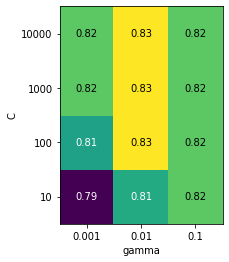

In [16]:
from matplotlib import pyplot as plt


def heatmap(values, xlabel, ylabel, xticklabels, yticklabels, cmap=None,
            vmin=None, vmax=None, ax=None, fmt="%0.2f"):
    if ax is None:
        ax = plt.gca()
    # plot the mean cross-validation scores
    img = ax.pcolor(values, cmap=cmap, vmin=vmin, vmax=vmax)
    img.update_scalarmappable()
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_xticks(np.arange(len(xticklabels)) + .5)
    ax.set_yticks(np.arange(len(yticklabels)) + .5)
    ax.set_xticklabels(xticklabels)
    ax.set_yticklabels(yticklabels)
    ax.set_aspect(1)

    for p, color, value in zip(img.get_paths(), img.get_facecolors(),
                               img.get_array()):
        x, y = p.vertices[:-2, :].mean(0)
        if np.mean(color[:3]) > 0.5:
            c = 'k'
        else:
            c = 'w'
        ax.text(x, y, fmt % value, color=c, ha="center", va="center")
    return img


results = pd.DataFrame(rbf_grid.cv_results_)

scores = np.array(results.mean_test_score).reshape(len(param_grid['classifier__C']),
                                                   len(param_grid['classifier__gamma']))

heatmap(scores, xlabel='gamma', xticklabels=param_grid['classifier__gamma'], ylabel='C',
        yticklabels=param_grid['classifier__C'], cmap="viridis")
plt.show()

In [17]:

from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

pipe = Pipeline([
    ('preprocessing', preprocess_pipeline),
    ('classifier', SVC(kernel='poly'))])

param_grid = {
    'classifier__degree': [1, 2, 3, 4, 5],
    'classifier__C': [10 ** (-2), 10 ** (-1), 1, 10 ** (1), 10 ** (2)],
    'classifier__coef0': [0, 1]

    # 'classifier__degree': [1,2,3,4],
    # 'classifier__C': [1, 5,10,15],
    # 'classifier__coef0': [0,0.5,0.9, 1]

    # 'classifier__degree': [1, 2, 3],
    # 'classifier__C': [2.87, 2.88, 2.89, 2.9],
    # 'classifier__coef0': [0.85, 0.86, 0.87, 0.88, 0.89]
}

poly_grid = GridSearchCV(pipe, param_grid, cv=kfold)

poly_grid.fit(X_train, y_train)
print(poly_grid.best_params_)

models.append(('SVM poly', poly_grid.best_estimator_))

{'classifier__C': 1, 'classifier__coef0': 1, 'classifier__degree': 4}


In [18]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

pipe = Pipeline([
    ('preprocessing', preprocess_pipeline),
    ('classifier', RandomForestClassifier(random_state=70))])

param_grid = {
    # "classifier__max_depth": [1, 5, 10, 20, 30, 40, 50],
    # "classifier__max_features": [ 'sqrt'],
    # "classifier__n_estimators":[1, 5, 10, 20, 30, 40, 50]

    "classifier__max_depth": [20, 30, 50],
    "classifier__n_estimators": [20, 30, 50],
    'classifier__criterion': ['gini', 'entropy', 'log_loss']

    # "classifier__max_depth": [15, 20, 25, 30],
    # "classifier__max_features": [ 'sqrt', 'log2'],
    # "classifier__n_estimators":[100]
}

tree_grid = GridSearchCV(pipe, param_grid, cv=kfold)

tree_grid.fit(X_train, y_train)
print(tree_grid.best_params_)
models.append(('random forest', tree_grid.best_estimator_))

{'classifier__criterion': 'gini', 'classifier__max_depth': 30, 'classifier__n_estimators': 50}


In [18]:
from sklearn import metrics

Method = []
precision_score = []
recall_score = []
f1_score = []
accuracy_score = []

for name, model in models:
    print("name: {}".format(name))
    print("precision_score: {}".format(metrics.precision_score(y_test, model.predict(X_test))))
    print("recall_score: {}".format(metrics.recall_score(y_test, model.predict(X_test))))
    print("f1_score: {}".format(metrics.f1_score(y_test, model.predict(X_test))))
    print("accuracy_score: {}".format(metrics.accuracy_score(y_test, model.predict(X_test))))
    Method.append(name)
    precision_score.append(metrics.precision_score(y_test, model.predict(X_test)))
    recall_score.append(metrics.recall_score(y_test, model.predict(X_test)))
    f1_score.append(metrics.f1_score(y_test, model.predict(X_test)))
    accuracy_score.append(metrics.accuracy_score(y_test, model.predict(X_test)))
    output = pd.DataFrame({'PassengerId': test_data.PassengerId, 'Survived': model.predict(test_data)})
    output.to_csv(name + '.csv', index=False)

name: SVM rbf
precision_score: 0.9107142857142857
recall_score: 0.6623376623376623
f1_score: 0.7669172932330827
accuracy_score: 0.8268156424581006
name: SVM poly
precision_score: 0.9074074074074074
recall_score: 0.6363636363636364
f1_score: 0.7480916030534351
accuracy_score: 0.8156424581005587


In [20]:
 # models=[]